# INMET DATA PREPROCESSING

#### Import modules and libraries

In [89]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Load INMET metheorlogical stations data

In [90]:
inmet = pd.read_csv('../Dados/Clean/INMET.csv', index_col=0)

inmet.set_index(pd.to_datetime(inmet.index), inplace=True); inmet.shape

(108864, 65)

#### Load water bag catalog and incident clusters

In [92]:
bolsoes = pd.read_csv('../Dados/Catalog/water_bag_catalog_google.csv', index_col=0)
clusters = pd.read_csv('../Dados/Catalog/water_bag_clusters.csv', index_col=0)

bolsoes.shape, clusters.shape

((3140, 20), (2983, 20))

### Load labeled time series

In [95]:
event_ts = pd.read_csv('../Dados/Transform/waterbag_timeserie_inmet.csv', index_col=0)

event_ts.set_index(pd.to_datetime(event_ts.index), inplace=True); event_ts.shape

(108863, 4)

---
# 1. Preprocessing

### Create events collection
   0. Event id
   1. Start time
   2. End time
   3. Group

In [96]:
events = bolsoes[['EVENTO_INICIO', 'EVENTO_FIM']].apply(pd.to_datetime)
events = events.join(clusters['sublabel'], how='inner')

display(events.head(4)); display(events.shape)

,EVENTO_INICIO,EVENTO_FIM,sublabel
EVENTO_ID,,,
1258,2015-09-12 20:12:00,2015-09-13 03:39:00,12
1259,2015-09-12 22:13:00,2015-09-13 01:21:00,-1
1260,2015-09-12 22:15:00,2015-09-13 01:20:00,-1
1261,2015-09-12 22:16:00,2015-09-13 01:20:00,-1


(2983, 3)

---
# Preliminary modeling - Hourly incident model

#### Import preprocessing and machine learning modules

In [98]:
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr

classifiers = dict(all_estimators('classifier'))

## Data transformation

In [99]:
#### Extract features dataset - Time serie section after first recorded incident
X = inmet[inmet.index > events['EVENTO_INICIO'].min()].iloc[:-1].copy()
print('Time serie extraction:', X.shape)

#### Drop X empty columns and rows
X = X.loc[:, X.isna().mean() < 1]; print('Drop empty columns: ', X.shape)
X = X.loc[X.isna().mean(1) < 1]; print('Drop empty rows: ', X.shape)

#### Scale X
X = pd.DataFrame(mms().fit_transform(X), columns=X.columns, index=X.index)

#### Interpolate X missing values
X = X.interpolate('linear')

#### Fill missing values with the minimum column value
for col in X:
    X[col].fillna(X[col].min(), inplace=True)

#### Extract target label variable
Y = event_ts['label'].loc[X.index].copy()

Time serie extraction: (58922, 65)
Drop empty columns:  (58922, 52)
Drop empty rows:  (58910, 52)


## Split train and test samples

In [100]:
#### Splitter Instance
guss = GroupUnderSampleSplit(
    train_size=0.79, train_prct=1,             # related to minority class size in given sample   # related to minotiy class size in train and test sets
    test_size=0.2, test_prct=None,
)

#### Train and test x and y dataframes
xt, xe, yt, ye = guss.undersample(
    X, Y, # cnt=None, shuffle=False, random_state=0
)

print_cls_cnt(Y, yt.index, ye.index)

c:\Users\luisr\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=1.0 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


,Train set,Test set
Class,,
0,4487,48742
1,4488,1193


## Modeling

In [101]:
gbc = classifiers['GradientBoostingClassifier']

#### Fit model with train data
model = gbc(n_estimators=100, verbose=0).fit(xt, yt)

#### Make predictions
yhat = model.predict(xe)

#### Evaluate predictions
print(cr(ye, yhat))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     48742
           1       0.09      0.80      0.17      1193

    accuracy                           0.81     49935
   macro avg       0.54      0.81      0.53     49935
weighted avg       0.97      0.81      0.88     49935



#### Feature importance

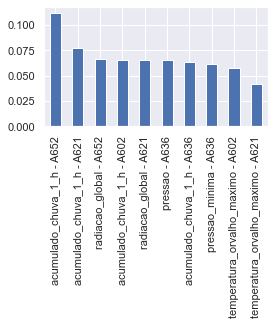

In [102]:
fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

ax = fi.head(10).plot.bar(figsize=(4, 2.2))

---
# Exploratory Data Analaysis

#### Events starting at the same time

In [72]:
event_count = events['EVENTO_INICIO'].value_counts()
dup_events = event_count[event_count>1].index
dup_events = events.set_index('EVENTO_INICIO').loc[dup_events]

dup_events.shape

(116, 2)

#### Events at the same time with more than one label

In [73]:
(dup_events.groupby('EVENTO_INICIO').nunique()!=1).mean()

EVENTO_FIM    0.964286
sublabel      0.571429
dtype: float64

#### Event time frequency

In [74]:
event_ts['label'].value_counts() / len(event_ts)

0    0.947696
1    0.052304
Name: label, dtype: float64

#### Hour (row) count per number of incidents

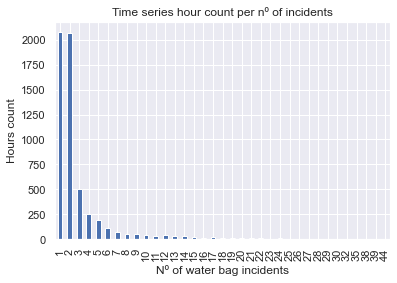

In [75]:
ax = event_ts['events'].value_counts().sort_index()[1:].plot.bar(title='Time series hour count per nº of incidents')
ax.set(xlabel='Nº of water bag incidents', ylabel='Hours count'); plt.show()

### Correlation analysis

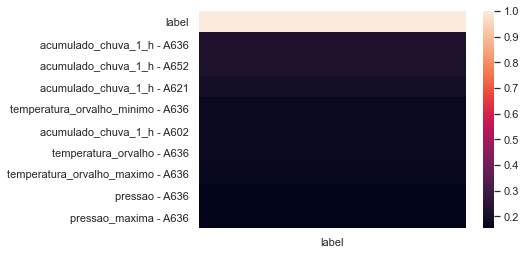

In [76]:
corr = pd.concat([X, Y], 1).corr()[[Y.name]].sort_values(Y.name, ascending=False)

ax = sns.heatmap(corr.head(10))